# Poisson's equation 

As an example of a multi-dimensional boundary value problem, let's try to solve Poisson's equation

$$\nabla^2 V(\vec{r}) = \rho(\vec{r})$$

(or Laplace's equation for $\rho=0$) with either $V$ or $\vec{\nabla} V$ specified on the boundary. 

First we can finite-difference the equation. In 2D, with grid points labelled by $(i,j)$ this gives

$${V_{i+1,j}-2V_{i,j}+V_{i-1,j}\over h^2} + {V_{i,j+1}-2V_{i,j}+V_{i,j-1}\over h^2} = \rho_{i,j}$$

where we set the grid spacing to $h$ in both directions for simplicity. Collecting terms,

$$V_{i+1,j}+V_{i-1,j} + V_{i,j+1}+V_{i,j-1}  -4V_{i,j}  = h^2\rho_{i,j}$$

or

$$V_{i,j} = {V_{i+1,j}+V_{i-1,j} + V_{i,j+1}+V_{i,j-1}\over 4} - {h^2\rho_{i,j}\over 4}.$$(laplace)

There are a few different ways we can try to solve this.

## Relaxation: Jacobi and Gauss-Seidel

Equation {eq}`laplace` shows that $V_{i,j}$ is the average of $V$ on the neighbouring grid cells plus an extra term from the charge density. This suggests a simple algorithm that we could use to relax to a solution from a starting guess:

$$V^{n+1}_{i,j} = {1\over 4}\left(V^n_{i+1,j}+V^n_{i-1,j} + V^n_{i,j+1}+V^n_{i,j-1}\right) - {1\over 4}h^2\rho_{i,j}.$$

There are two versions of this in which you either apply this rule to the whole grid, i.e use the values $\{V^n\}$ on the right hand side to update all the grid points (Jacobi method) or you update one grid cell at a time and use the new values $V^{n+1}_{i,j}$ on the right hand side when updating neighbouring cells (Gauss-Seidel method). The second method converges a factor of 2 faster (see the discussion in Numerical Recipes section 19.5). 

As an example, let's solve the 2D potential around a circular conductor, with $V=1$ on the conductor and $V=0$ at the boundaries. (We'll take $\rho=0$ so this is Laplace's equation).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time

In [2]:
def set_bcs(n):
    # Create a mask to set the boundary points
    mask = np.zeros([n,n],dtype='bool')
    x = np.linspace(-1,1,n)
    xsqr = np.outer(x**2,np.ones(n))
    rsqr = xsqr+xsqr.T
    R = 0.1
    mask[rsqr<R**2] = True
    mask[:,0] = True
    mask[0,:] = True
    mask[-1,:] = True
    mask[:,-1] = True
    bc = np.zeros([n,n])
    bc[rsqr<R**2] = 1.0
    return mask, bc

def laplace(mask, bc, niter, V, make_plot=True):
        
    deltaV = np.zeros(niter)
    t0 = time.time()
    for i in range(niter):
        Vnew = 0.25 * (np.roll(V,1,0) + np.roll(V,-1,0) + 
                       np.roll(V,1,1) + np.roll(V,-1,1))
        deltaV[i] = np.max(np.abs(Vnew[mask == False]-V[mask == False]))
        V = Vnew
        V[mask] = bc[mask]

        if i%1000 == 0 and make_plot:
            n = len(V[0,:])
            plt.plot(np.arange(n), V[n//2,:])

    print('%d iterations took %lg seconds' %(niter, time.time()-t0))

    return V, deltaV

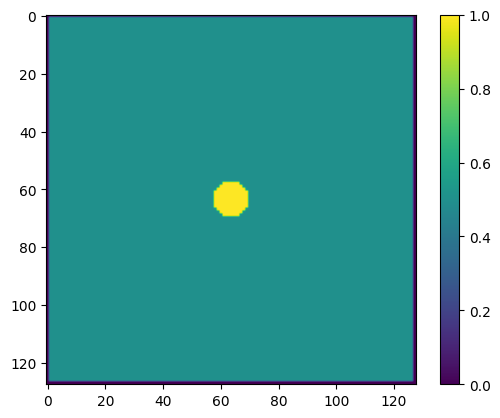

32768 iterations took 3.13497 seconds


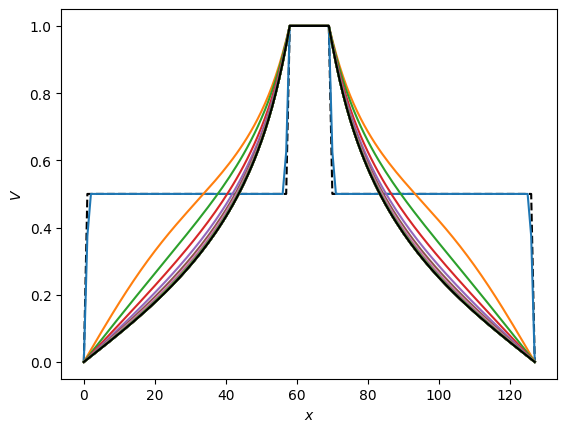

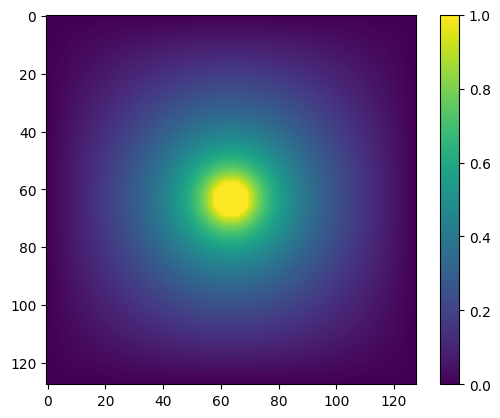

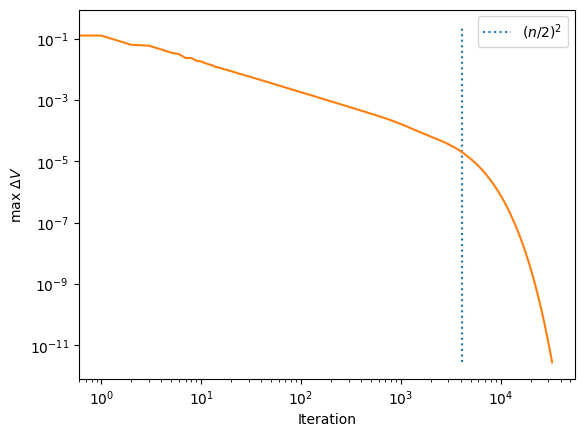

In [13]:
# Solve Laplace's equation with Jacobi method
n = 128
mask, bc = set_bcs(n)

# Initial guess for the potential 
V = np.zeros([n,n]) + 0.5
V[mask] = bc[mask]

plt.imshow(V)
plt.colorbar()
plt.show()
plt.clf()
plt.plot(np.arange(n), V[int(n/2),:], 'k--')
plt.ylabel(r'$V$')
plt.xlabel(r'$x$')

# The diffusion time across the grid is ~n^2 so scale the number of iterations accordingly
V_jacobi, deltaV_jacobi = laplace(mask, bc, 2*n*n, V)
    
plt.plot(np.arange(n), V_jacobi[int(n/2),:], 'k')
plt.show()

plt.clf()
plt.imshow(V_jacobi)
plt.colorbar()
plt.show()

plt.clf()
plt.plot([n**2/4,n**2/4], [min(deltaV_jacobi),max(deltaV_jacobi)], ':', label=r'$(n/2)^2$')
plt.plot(np.arange(len(deltaV_jacobi)), deltaV_jacobi)
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'max $\Delta V$')
plt.xlabel('Iteration')
plt.legend()
plt.show()

Notes

- information propagates into the domain from the boundaries (at the center and the edges) where we specify the value of the potential
- we can think of the successive iterations as evolving the system in time, in which case we are solving a diffusion equation ($\partial/\partial t\propto \nabla^2$). In a diffusion problem, the distance travelled is $\propto \sqrt{t}$, or turning this around the time taken to travel a distance $L$ is $t\propto L^2$. In our case, we need the information from the boundaries to propagate across the grid, so we need to do a number of iterations $\approx n^2$ to get a converged solution.
- You can see the diffusion time across the grid appearing in the last plot where the solution converges rapidly after we've done $\sim n^2$ iterations. (The vertical dashed line corresponds the diffusion time across half the box, ie. to number of iterations equal to $(n/2)^2$).
- if you run the code for a fixed number of iterations, you will find that the runtime scales $\propto n^2$. However because the time taken to diffuse across the grid also scales $\propto n^2$, the overall runtime increases $\propto n^4$! So this is a really slow method for large problems.

If you want to have some fun, try changing the boundary conditions, e.g. a plane-parallel capacitor:

In [4]:
def set_bcs_capacitor(n):
    mask = np.zeros([n,n],dtype='bool')
    x1 = 3*n//8
    x2 = n-x1
    mask[:, x2] = True
    mask[:, x1] = True
    bc = np.zeros([n,n])
    bc[mask] = 1.0
    mask[:,0] = True
    mask[0,:] = True
    mask[-1,:] = True
    mask[:,-1] = True
    return mask, bc

## Multigrid method

One way to try to speed up this kind of relaxation scheme is to use a set of grids with different resolutions. On a coarse grid with large spacing, the information from the boundaries can diffuse quickly across the whole grid. This information can then be passed down to successively finer spaced grids where the small scale structure is filled in. These methods are known as **multigrid**.

In [17]:
# Visualize matrices as a color map
def plot_matrices(A,titles=[],nmax=4):
    n = len(A)
    if titles==[]:
        titles = [""]*n
    if n>nmax:
        nx = nmax
    else:
        nx = n
    for j in range(int(np.floor(n/nmax))+1):        
        plt.clf()
        plt.figure(figsize=(nx*4,4))
        jmax = nmax*(j+1)
        if jmax > n:
            jmax = n
        for i,AA in enumerate(A[nmax*j:jmax]):
            plt.subplot(1, nx, i+1)
            plt.imshow(AA)
            plt.colorbar()
            plt.title(titles[nmax*j + i])
        plt.show()

We're going to borrow two functions from last year's course by Jon Sievers. These take in a matrix and return a matrix with either half the size (`deres`) or twice the size (`upres`). There are many ways to do this (typically you would use some kind of interpolation depending on the problem), here we downscale by replacing each set of 4 pixels by a single pixel with the maximum value of the 4, and we upscale by copying each pixel 4 times.

In [18]:
# A simple way to decrease or increase the number of grid points by a factor of 2
# From https://github.com/sievers/phys512-2022/tree/master/pdes

def deres(map):
    tmp=np.maximum(map[::2,::2],map[1::2,::2])
    tmp=np.maximum(tmp,map[::2,1::2])
    tmp=np.maximum(tmp,map[1::2,1::2])
    return tmp

def upres(map):
    n=map.shape[0]
    tmp=np.zeros([2*n,2*n])
    tmp[::2,::2]=map
    tmp[1::2,::2]=map
    tmp[::2,1::2]=map
    tmp[1::2,1::2]=map
    return tmp

<Figure size 640x480 with 0 Axes>

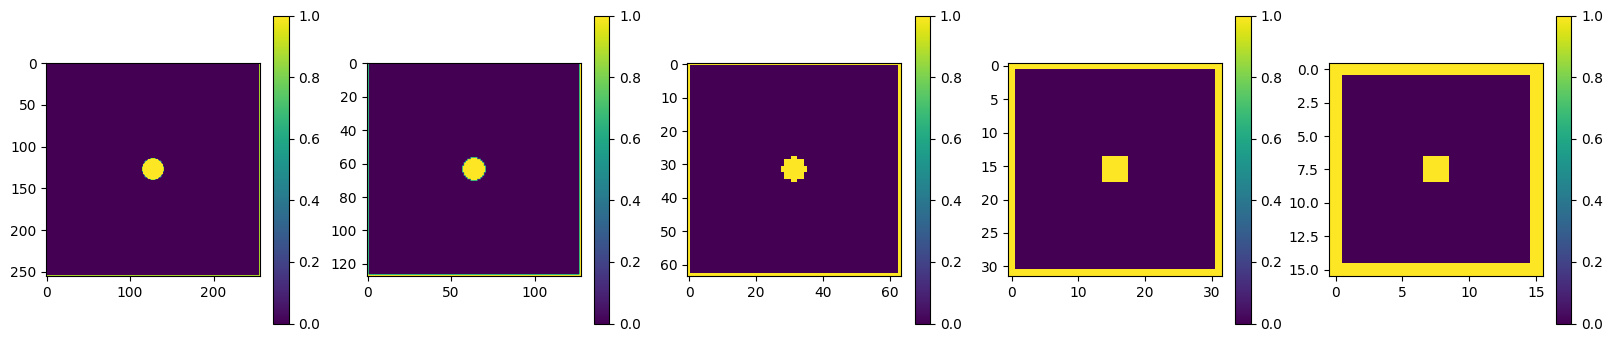

<Figure size 640x480 with 0 Axes>

<Figure size 2000x400 with 0 Axes>

In [19]:
# Let's run a quick test of these functions

# Start with the initial condition from the Laplace problem above 
# and deres a number of times

n = 256
mask, bc = set_bcs(n)

masks = [None] * 5
masks[0] = mask

for i in range(1,5):
    masks[i] = deres(masks[i-1])

plot_matrices(masks, nmax=5)

100 iterations took 0.0050118 seconds
n = 16, Delta V = 0.000255252
100 iterations took 0.00432301 seconds
n = 32, Delta V = 0.00054352
100 iterations took 0.00933909 seconds
n = 64, Delta V = 0.000653078
32768 iterations took 3.28993 seconds
n = 128, Delta V = 5.16809e-14
Total time taken = 3.31199 seconds


<Figure size 640x480 with 0 Axes>

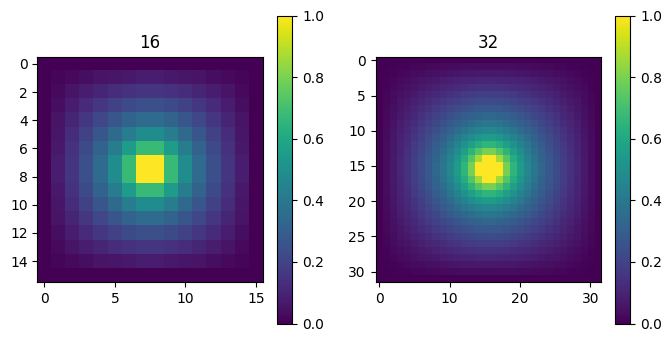

<Figure size 640x480 with 0 Axes>

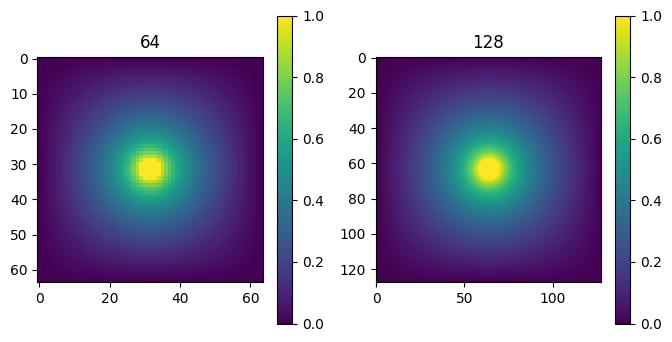

<Figure size 640x480 with 0 Axes>

<Figure size 800x400 with 0 Axes>

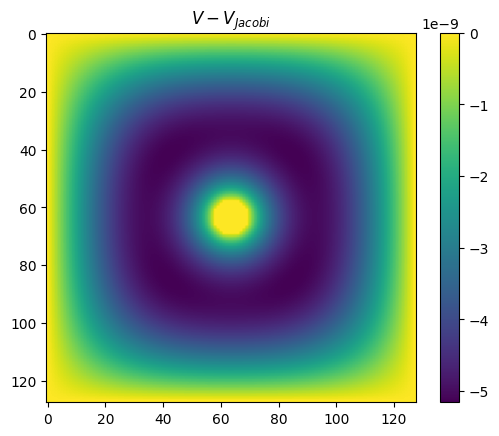

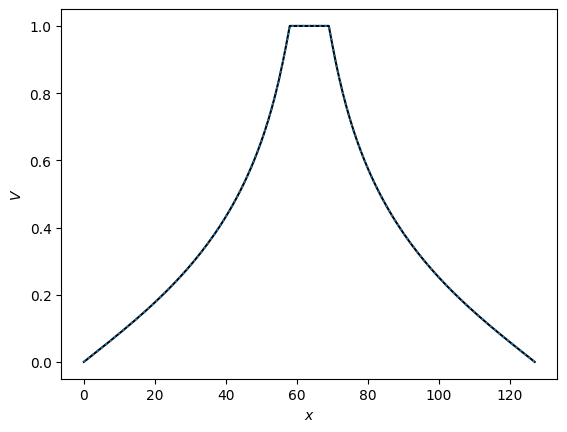

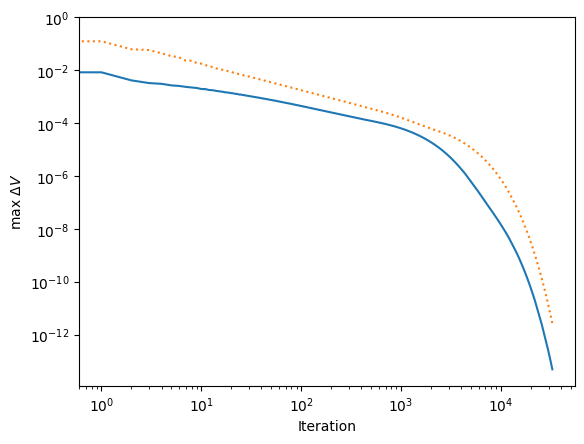

In [21]:
# Solve Laplace's equation with a multigrid method

t0 = time.time()

n = 128
mask, bc = set_bcs(n)

# Initial guess for the potential
V0 = np.ones_like(bc) * 0.5

# First go down in resolution from fine to coarse
# and calculate the smoothed bc, mask and V arrays at each step
npass = 3
bcs = [bc,]
masks = [mask,]
Vs = [V0,]
for i in range(npass):
    bcs.append(deres(bcs[i]))
    masks.append(deres(masks[i]))
    Vs.append(deres(Vs[i]))

# Now step back up, relaxing at each stage    
for i in range(npass,0,-1):
    n0 = bcs[i].shape[0]
    Vs[i], deltaV = laplace(masks[i], bcs[i], 100, Vs[i], make_plot=False)
    print('n = %d, Delta V = %lg' % (n0, deltaV[-1],))
    Vs[i-1] = upres(Vs[i])

# Run the final grid for 2*n*n interations so that we can see how it converges
# now that the solution has been preconditioned
n0 = bcs[0].shape[0]
nn = 2*n0*n0
Vs[0], deltaV = laplace(masks[0], bcs[0], nn, Vs[0], make_plot=False)
print('n = %d, Delta V = %lg' % (n0, deltaV[-1],))

print('Total time taken = %lg seconds' % (time.time()-t0,))

titles = ["%d" % (V.shape[0],) for V in Vs]
plot_matrices(Vs[::-1], nmax = 2, titles=titles[::-1])

plt.clf()
plt.title(r'$V-V_{Jacobi}$')
plt.imshow(Vs[0]-V_jacobi)
plt.colorbar()
plt.show()

plt.clf()
plt.plot(np.arange(n), Vs[0][int(n/2),:], 'k')
plt.plot(np.arange(n), V_jacobi[int(n/2),:], ':')
plt.ylabel(r'$V$')
plt.xlabel(r'$x$')
plt.show()

plt.clf()
plt.plot(np.arange(len(deltaV)), deltaV)
plt.plot(np.arange(len(deltaV_jacobi)), deltaV_jacobi, ':')
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'max $\Delta V$')
plt.xlabel('Iteration')
plt.show()

The last plot shows that this method converges much more quickly. In particular, we can now get a much more reasonable low-accuracy solution in the first part of the curve (number of iterations << n^2). Whereas previously these solutions were completely wrong because the diffusion from the boundaries had travelled only a small distance, now the coarse grids have taken care of the global diffusion and so the overall solution is much more accurate.

The general idea of using some approximate scheme to improve the initial guess for a relaxation method is known as **preconditioning**, and is used in many codes. Here, we can think of the sequence of low resolution grids as a preconditioner for the final relaxation at full resolution.

## Further reading

- Good places to look for more detailed discussion of multigrid methods are Numerical Recipes 19.6 and in [Mike Zingale's course](https://zingale.github.io/computational_astrophysics/elliptic_multigrid/multigrid/multigrid.html) at Stonybrook.